In [13]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier

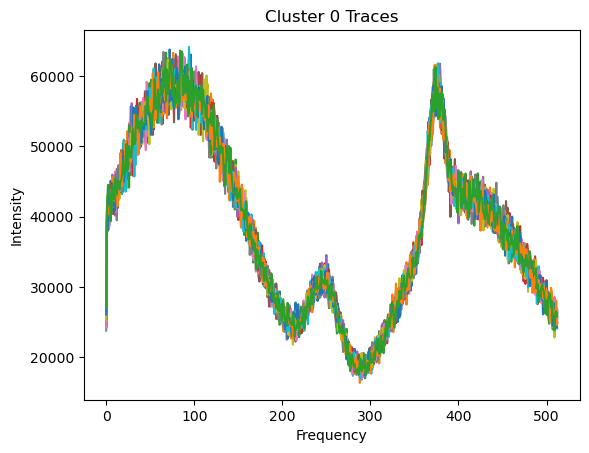

In [14]:
cluster_idx = 0
time_traces, spectra, phase, clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(100, n_clusters=4, outlier_fraction=0.05)
for i in range(100):
    if clusters[i] == cluster_idx:
        plt.plot(spectra[i], label=f'Trace {i+1}')
        plt.xlabel('Frequency')
        plt.ylabel('Intensity')
plt.title(f'Cluster {cluster_idx} Traces')
plt.show()

In [15]:
importlib.reload(umap_classifier)
importlib.reload(random_rm_trace_generator)

<module 'helper_scripts.random_rm_trace_generator' from '/cr/work/kastner/private/umap/rm_classifier/tutorials/notebooks/helper_scripts/random_rm_trace_generator.py'>

In [16]:
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", data_preparation={'target_data_type': "time"})

In [17]:
prepared_data=u_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft"}, 
                 log_filter=False,avg_pooling=4,verbose=False,
                 normalization=False,
                 suppress_dc=True)

In [18]:
embeddings=u_clas.embed(prepared_data, save_model="umap_model.pkl")

Embedding data with parameters: n_neighbors=40, min_dist=0.0, n_components=2, metric=braycurtis


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving UMAP model to umap_model.pkl


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


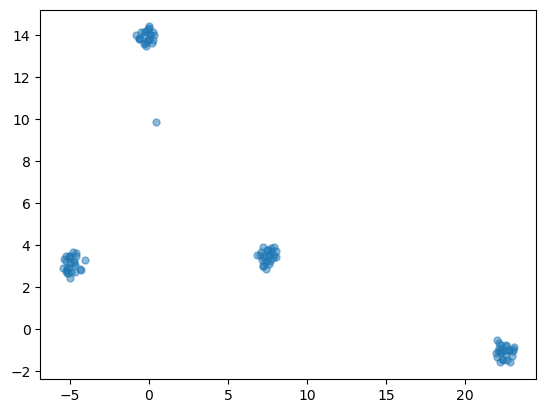

In [19]:
plt.plot(embeddings[:, 0], embeddings[:, 1], 'o', markersize=5, alpha=0.5)

In [20]:
clusters=u_clas.classify(embeddings, db_min_samples=10, db_eps=0.5)
u_clas.cluster_indices

Overriding db_min_samples with value 10 from kwargs.
Overriding db_eps with value 0.5 from kwargs.


array([0, 1, 2, 3])

In [21]:
def log(x):
    return np.log(x + 1e-10)

In [22]:
u_clas.save_cluster_trace(prepared_data, clusters, trace_statistic="mean")

Saved 4 cluster traces with mean statistic.


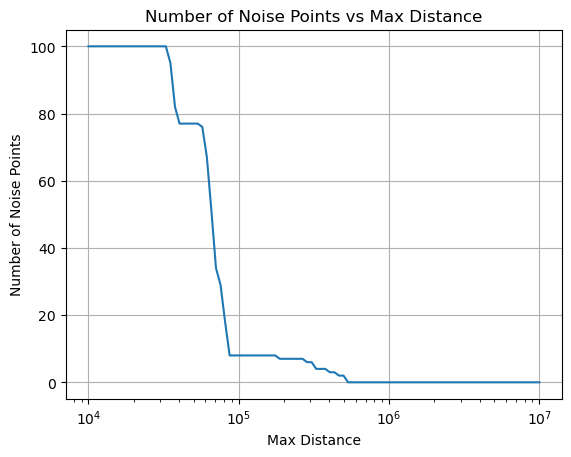

In [23]:
n_noise=[]
for max_distance in np.logspace(3,7,100):
    predictions, min_distances=u_clas.minimum_distance_prediction(prepared_data, max_distance=max_distance)
    n_noise.append(np.sum(predictions == -1))

plt.plot(np.logspace(4,7,100), n_noise)
plt.xscale('log')
plt.xlabel('Max Distance')
plt.ylabel('Number of Noise Points')
plt.title('Number of Noise Points vs Max Distance')
plt.grid(True)
plt.show()

In [24]:
u_clas.save_cluster_trace(prepared_data,clusters,trace_statistic="mean")
u_clas.save_cluster_trace(prepared_data,clusters,trace_statistic="std")
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_data)

Saved 4 cluster traces with mean statistic.
Saved 4 cluster traces with std statistic.


In [27]:
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_data, min_logl=-2000)
predictions

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1])

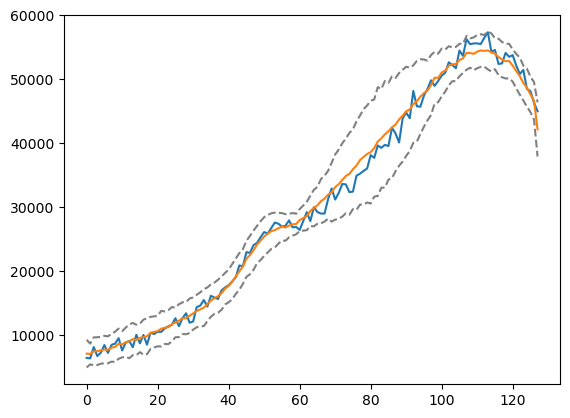

In [43]:
idx=59
cluster_idx=clusters[idx]
plt.plot(prepared_data[idx])
plt.plot(u_clas.cluster_mean_traces[cluster_idx])
plt.plot(u_clas.cluster_mean_traces[cluster_idx] + u_clas.cluster_std_traces[cluster_idx], linestyle='--', color='gray')
plt.plot(u_clas.cluster_mean_traces[cluster_idx] - u_clas.cluster_std_traces[cluster_idx], linestyle='--', color='gray')